In [1]:
import numpy as np 
import torch
import torchaudio
from hw_tts.model.baseline_model import BaselineModel
from hw_tts.model.voicefilter import VoiceFilter, ADvector
from hw_tts.loss.SDRLoss import SpExPlussLoss
from hw_tts.loss.MSELossWrapper import MSELossWrapper
from hw_tts.loss.AsymLoss import AsymmetricL2Loss
from pathlib import Path
from torch.utils.data import ConcatDataset, DataLoader
from hw_tts.utils.audio import Audio
from torch.optim import Adam
from hw_tts.datasets import CustomDirAudioDataset
import random
from torch.nn.utils.rnn import pad_sequence

from tqdm.auto import tqdm
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip
kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip


In [2]:
audio = Audio()

In [3]:
class CustomDirAudioDataset:
    def __init__(self, dir, *args, **kwargs):
        self.speaker_lst = []
        self.speaker_audio_dict = {}
        data = []
        for audio_file in Path(dir).rglob("*-target.[mwflac4]*"):
            base_key = audio_file.stem[:-len("-target")]
            suffix = audio_file.suffix
            mixed_file = audio_file.parent / f"{base_key}-mixed{suffix}"
            ref_file = audio_file.parent / f"{base_key}-ref{suffix}"
            if mixed_file.exists() and ref_file.exists():
                speaker_target, speaker_noise, *_ = base_key.split("_")
                data.append({
                    "speaker_target": speaker_target,
                    "speaker_noise": speaker_noise,
                    "target_path": str(audio_file),
                    "mix_path": str(mixed_file),
                    "reference_path": str(ref_file)
                })
                if speaker_target not in self.speaker_audio_dict:
                    self.speaker_lst.append(speaker_target)
                    self.speaker_audio_dict[speaker_target] = []
                self.speaker_audio_dict[speaker_target].append(str(ref_file))
        self.data = data
        self._index = self.data

    def __getitem__(self, ind):
        data_dict = self._index[ind]
        target_audio_wave, _ = torchaudio.load(data_dict["target_path"])
        mix_audio_wave, _ = torchaudio.load(data_dict["mix_path"])
        reference_audio_wave, _ = torchaudio.load(data_dict["reference_path"])
        speaker_target = self.speaker_lst.index(data_dict['speaker_target'])
        target_audio_spec, target_phase = audio.wav2spec(target_audio_wave)
        mix_audio_spec, mix_phase = audio.wav2spec(mix_audio_wave)
        reference_audio_spec, reference_phase = audio.wav2spec(reference_audio_wave)
        return {
            "speaker_target": speaker_target,
            "target_audio": target_audio_wave,
            "reference_audio": reference_audio_wave,
            "mix_audio": mix_audio_wave,
            "mix_phase": mix_phase,
            "target_phase": target_phase,
            "reference_phase": reference_phase,
            "target_spectrogram": target_audio_spec,
            "mix_spectrogram": mix_audio_spec,
            "reference_spectrogram": reference_audio_spec,
        }
    
    def __len__(self):
        return len(self._index)
    
    
class TripletAudioDataset(CustomDirAudioDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __getitem__(self, ind):
        # Anchor and Positive will be from the same speaker
        anchor_speaker = self.speaker_lst[ind]
        anchor_audios = self.speaker_audio_dict[anchor_speaker]
        
        anchor_audio_path, positive_audio_path = random.sample(anchor_audios, 2)
        anchor_audio_wave, _ = torchaudio.load(anchor_audio_path)
        positive_audio_wave, _ = torchaudio.load(positive_audio_path)
        
        anchor_audio_spec = audio.wav2spec(anchor_audio_wave)[0]
        positive_audio_spec = audio.wav2spec(positive_audio_wave)[0]
        negative_speaker = random.choice([s for s in self.speaker_lst if s != anchor_speaker])
        negative_audios = self.speaker_audio_dict[negative_speaker]
        
        negative_audio_path = random.choice(negative_audios)
        negative_audio_wave, _ = torchaudio.load(negative_audio_path)
        negative_audio_spec = audio.wav2spec(negative_audio_wave)[0]
        return {
            'anchor': anchor_audio_spec,
            'positive': positive_audio_spec,
            'negative': negative_audio_spec,
            'speaker_target': anchor_speaker
        }
    
    def __len__(self):
        return len(self.speaker_lst)

In [4]:
def collate_fn(dataset_items: list[dict]) -> dict:
    """
    Collate and pad fields in dataset items
    """
    result_batch = dict()
    for key in dataset_items[0].keys():
        match key:
            case "target_spectrogram" | "mix_spectrogram" | "reference_spectrogram":
                result_batch[f"{key}_len"] = torch.tensor(
                    data=[item.get(key).shape[-1] for item in dataset_items]
                )
                result_batch[key] = pad_sequence(
                    sequences=[
                        torch.squeeze(item.get(key), dim=0).t()
                        for item in dataset_items
                    ],
                    batch_first=True,
                )
            case "target_audio" | "mix_audio" | "reference_audio":
                result_batch[f"{key}_len"] = torch.tensor(
                    data=[item.get(key).shape[-1] for item in dataset_items]
                )
                result_batch[key] = pad_sequence(
                    sequences=[
                        torch.squeeze(item.get(key), dim=0).t()
                        for item in dataset_items
                    ],
                    batch_first=True,
                )
            case "mix_phase" | "target_phase" | "reference_phase":
                result_batch[key] = pad_sequence(
                    sequences=[
                        item.get(key).transpose(1, 0)
                        for item in dataset_items
                    ],
                    batch_first=True,
                )
            case _:
                result_batch[key] = [item.get(key) for item in dataset_items]
    result_batch['mix_phase'] = result_batch['mix_phase'].transpose(2, 1)
    result_batch['speaker_target'] = torch.tensor(result_batch['speaker_target'])
    result_batch["target_spectrogram"] = result_batch["target_spectrogram"].permute(0, 2, 1)
    result_batch["mix_spectrogram"] = result_batch["mix_spectrogram"].permute(0, 2, 1)
    result_batch["reference_spectrogram"] = result_batch["reference_spectrogram"].permute(0, 2, 1)
    return result_batch

In [5]:
def dvec_collate_fn(dataset_items: list[dict]) -> dict:
    """
    Collate and pad fields in dataset items
    """
    result_batch = dict()
    for key in dataset_items[0].keys():
        if key != 'speaker_target':
            result_batch[key] = pad_sequence(
                                sequences=[
                                    torch.squeeze(item.get(key), dim=0).t()
                                    for item in dataset_items
                                ],
                                batch_first=True,
                    )
        else:
            result_batch[key] = [item[key] for item in dataset_items]
    return result_batch
dataset = TripletAudioDataset('/home/vladimir/PycharmProjects/TTS/temp_datasets/train_easy')
BATCH_SIZE, EXAMPLES, EMB_DIM = 4, 4, 128
person_dataloader = DataLoader(dataset, batch_size=16, pin_memory=True, shuffle=True, collate_fn =dvec_collate_fn)
criterion = torch.nn.TripletMarginWithDistanceLoss(margin=0.2).cuda()
model = ADvector().cuda()
optimizer = Adam(model.parameters(), lr=1e-4)

In [6]:
n_epochs = 1000
pbar = tqdm(total = n_epochs * len(person_dataloader))
for epoch in range(n_epochs):
    total_loss = 0 
    for i, batch in enumerate(person_dataloader):
        optimizer.zero_grad()
        anchors = batch['anchor'].cuda()
        positives = batch['positive'].cuda()
        negatives = batch['negative'].cuda()
        anchor_embedding = model(anchors)
        positive_embedding = model(positives)
        negative_embedding = model(negatives)
        loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        optimizer.step()
        pbar.update(1)
        total_loss += loss.detach().item()
    pbar.set_description(desc=f"Loss: {total_loss:2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: ADvector.forward() missing 2 required positional arguments: 'positive' and 'negative'

In [ ]:
# Collect embeddings and labels
embeddings = []
labels = []

# Assume you run this after your training loop
model.eval()
with torch.no_grad():
    for _ in range(10):
        for i, batch in enumerate(person_dataloader):
            anchors = batch['anchor'].cuda()
            anchor_embedding = model(anchors).cpu().numpy()
            embeddings.append(anchor_embedding)
            labels.append(batch['speaker_target'])  # Assuming that your dataset returns a 'speaker_target'

# Concatenate all the embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 10))

for i, label in enumerate(set(labels)):
    idxs = [j for j, x in enumerate(labels) if x == label]
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], label=label)

plt.legend()
plt.show()

In [ ]:
embedder = torch.load('embedder4.pt')

In [6]:
from hw_tts.model.voicefilter import VoiceFilter
from hw_tts.collate_fn.collate import collate_fn
dataset = CustomDirAudioDataset('/home/vladimir/PycharmProjects/TTS/temp_datasets/train_easy')
dataloader = DataLoader(dataset, 4, collate_fn=collate_fn, pin_memory=True, pin_memory_device='cuda')
model = VoiceFilter().to('cuda')
criterion = AsymmetricL2Loss()
optimizer = Adam(model.parameters(), lr=0.01)


In [7]:
optimizer = Adam(model.parameters(), lr=0.001)


In [8]:
"""Train main model"""
from tqdm.auto import tqdm
pbar = tqdm(total = 100 * len(dataloader))
for epoch in range(1):
    loss = 0 
    for batch in dataloader:
        for key in batch.keys():
            if 'spectrogram' in key:
                batch[key] = batch[key].to('cuda')
        
        optimizer.zero_grad()
        with torch.no_grad():
            batch_size = batch['reference_spectrogram'].shape[0]
            dvec = embedder.make_embedding(batch['reference_spectrogram'].transpose(1, 2))
            batch.update({
                'dvec': dvec
            })
        update = model(**batch)
        batch.update(update)
        res = criterion(**batch)
        res['loss'].backward()
        optimizer.step()
        pbar.update(1)
        loss += res['loss'].detach().item()
    pbar.set_description(desc=f"Loss: {loss:2f}")
## 0.00618, 37 sec
## 0.00624, 36 sec with batchnorm.
# 1.65 -> 0.93 -> 0.87 -> 0.818 -> 0.76 -> 0.674

# 0.632365

  0%|          | 0/18100 [00:00<?, ?it/s]

NameError: name 'embedder' is not defined

In [9]:
from hw_tts.collate_fn.collate import collate_fn

from hw_tts.model.voicefilter_phase import VoiceFilterPhase
path = 'saved/models/voicefilter_phase/1101_113647/checkpoint-epoch75.pth'
kwargs = {
      "embedder_phase_path": "saved/models/dvec_config/1101_080955/checkpoint-epoch5.pth",
      "embedder_path": "saved/models/dvec_config/1101_073809/checkpoint-epoch5.pth",
      "specnet_path": "saved/models/voicefilter/1101_100712/checkpoint-epoch60.pth"
    }
model = VoiceFilterPhase(**kwargs)
model.load_state_dict(torch.load(path)['state_dict'])

<All keys matched successfully>

In [10]:
dataset = CustomDirAudioDataset('/home/vladimir/PycharmProjects/TTS/temp_datasets/train_easy')
dataloader = DataLoader(dataset, 4, collate_fn=collate_fn, pin_memory=True, pin_memory_device='cuda')
batchez = dataloader.__iter__()
batchez.__next__()
print()

In [11]:
batch = batchez.__next__()
batch.update(model(**batch))

In [12]:
# mask = batch['pred_mask'].detach().cpu()
batch.update(model.specnet(**batch))
i = 0
mix_phase = batch['mix_phase'][i].detach().cpu()
target_phase = batch['target_phase'][i].detach().cpu()
target_spec = batch['target_spectrogram'][i].detach().cpu()
pred_spec = batch['pred_spectrogram'][i].detach().cpu()
mix_spec = batch['mix_spectrogram'][i].detach().cpu()
pred_phase = batch['pred_phase'][i].detach().cpu()
mix_audio  = audio.spec2wav(pred_spec, mix_phase)
pred_audio = audio.spec2wav(pred_spec, pred_phase)
pred_audio = audio.spec2wav(target_spec, mix_phase)
true_audio = audio.spec2wav(batch['target_spectrogram'][i].detach().cpu(), target_phase)

In [13]:
def snr(est, target):
    return 20 * np.log10(np.linalg.norm(target) / (np.linalg.norm(target - est) + 1e-6) + 1e-6)

def si_sdr(est, target):
    alpha = (target * est).sum() / np.linalg.norm(target)**2
    return 20 * np.log10(np.linalg.norm(alpha * target) / (np.linalg.norm(alpha * target - est) + 1e-10) + 1e-10)

In [14]:
torch.mean(torch.square(mix_phase - target_phase))

tensor(4.3158)

In [15]:
torch.mean(torch.square(pred_phase - target_phase))

tensor(4.3828)

In [16]:
si_sdr(pred_audio, true_audio)

12.833063370933644

In [17]:
def griffin_lim(magnitude_spec, 
                initial_phase,
                window,
                num_iters=32, 
                n_fft=audio.n_fft, 
                hop_length=audio.hop_length,
                win_length=audio.win_length,
                momentum=0.99, 
                **kwargs):
    complex_spec = torch.polar(magnitude_spec, initial_phase)
    tprev = torch.tensor(0.0, dtype=magnitude_spec.dtype, device=magnitude_spec.device)
    for i in range(num_iters):
        signal = torch.istft(complex_spec, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window,
        )
        reconstruction = torch.stft(
            input=signal,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            window=window,
            center=True,
            pad_mode="reflect",
            normalized=False,
            onesided=True,
            return_complex=True,
        )
        reconstruction -= tprev * momentum
        tprev = reconstruction.clone()
        complex_spec = magnitude_spec * (reconstruction / (torch.abs(reconstruction) + 1e-9))
    final_phase = torch.angle(complex_spec)
    return final_phase

In [18]:
S = (torch.clamp(pred_spec, 0.0, 1.0) - 1.0) * -audio.min_level
S += audio.ref_level
S = 10.0 ** (S * 0.05)

In [19]:
griffin_phase= griffin_lim(S, initial_phase=mix_phase, n_fft=audio.n_fft,
                       hop_length=audio.hop_length,
                       win_length=audio.win_length,
                       window=torch.hann_window(audio.win_length),  n_iter=32, momentum=0)

In [20]:
si_sdr(audio.spec2wav(pred_spec, griffin_phase), true_audio)

2.229312846012068

In [21]:
si_sdr(pred_audio, true_audio)

12.833063370933644

In [22]:
si_sdr(mix_audio, true_audio)

3.105191799008934

In [23]:
import IPython

IPython.display.Audio(audio.spec2wav(pred_spec, mix_phase), rate=16_000)

In [24]:
import IPython

IPython.display.Audio(audio.spec2wav(target_spec, target_phase), rate=16_000)

In [25]:
import IPython

IPython.display.Audio(audio.spec2wav(target_spec, griffin_phase), rate=16_000)

In [26]:
si_sdr(true_audio[0], batch['target_audio'][0][:, :47880])

-68.66019286644521

In [27]:
si_sdr(batch['target_audio'][0][:47985], batch['target_audio'][0][:47985])

120.94691068422054

In [28]:
import IPython

IPython.display.Audio(mix_audio, rate=16_000)

In [29]:
IPython.display.Audio(true_audio, rate=16_000)

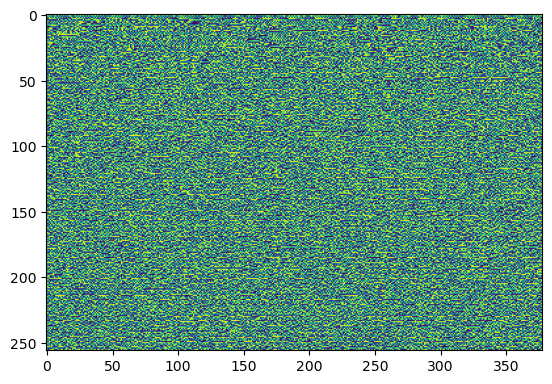

In [30]:
import matplotlib.pyplot as plt

plt.imshow(torch.atan(mix_phase))

In [43]:
batch['target_audio'][0]

tensor([[-6.1035e-05, -1.4435e-02, -2.3315e-02,  ...,  5.9448e-02,
          5.2094e-02,  4.3304e-02]])

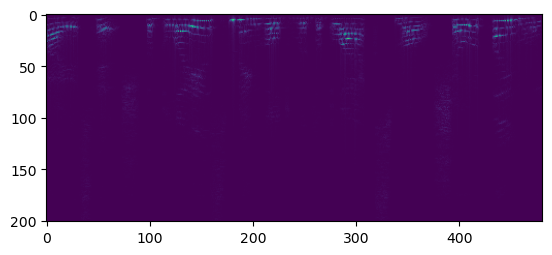

In [67]:
plt.imshow(torch.stft(batch['target_audio'][0].flatten(), n_fft=400, return_complex=True).imag.abs())

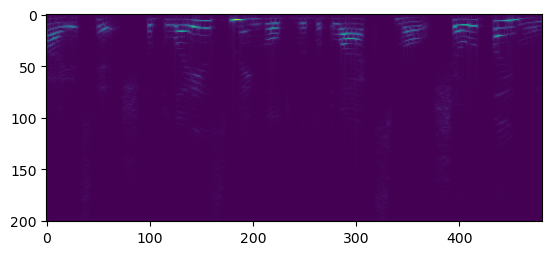

In [69]:
plt.imshow(torch.stft(batch['target_audio'][0].flatten(), n_fft=400, return_complex=True).abs())

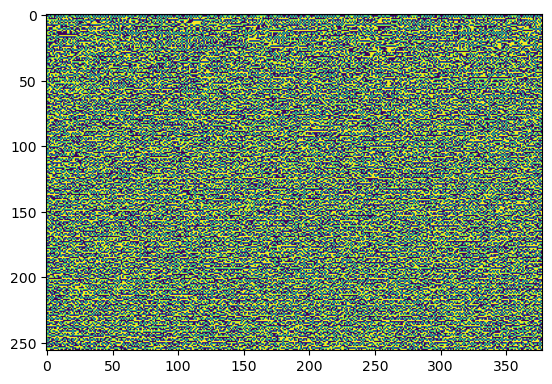

In [31]:
import matplotlib.pyplot as plt

plt.imshow(torch.angle(mix_phase))

In [32]:
def griffinlim(
    specgram,
    init_phase,
    window,
    n_fft: int,
    hop_length: int,
    win_length: int,
    power: float = 2.,
    n_iter: int=32,
    momentum: float = 0.99,
):

    momentum = momentum / (1 + momentum)

    shape = specgram.size()
    specgram = specgram.reshape([-1] + list(shape[-2:]))

    specgram = specgram.pow(1 / power)
    # initialize the phase
    tprev = torch.tensor(0.0, dtype=specgram.dtype, device=specgram.device)
    for _ in range(n_iter):
        inverse = torch.istft(
            specgram * angles, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window,
        )
        rebuilt = torch.stft(
            input=inverse,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            window=window,
            center=True,
            pad_mode="reflect",
            normalized=False,
            onesided=True,
            return_complex=True,
        )
        angles = rebuilt
        if momentum:
            angles = angles - tprev.mul_(momentum)
        angles = angles.div(angles.abs().add(1e-16))
        tprev = rebuilt
    waveform = torch.istft(
        specgram * angles, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window,
    )
    waveform = waveform.reshape(shape[:-2] + waveform.shape[-1:])
    return torch.angle(angles)